### By Vaasudevan Srinivasan ([vaasudevans.github.io](https://vaasudevans.github.io))
Created: April 9, 2019

Modified : April 11, 2019

In [1]:
# Download the datasets to this session

# IRIS dataset
!wget "https://raw.githubusercontent.com/VaasuDevanS/SVM-in-RemoteSensing/master/Implementation/Data/iris-data.txt" -qO "iris-data.txt"

# SVM for satellite imagery    
!wget "https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Data/Dataset.tif?raw=true" -qO "Dataset.tif"
!wget "https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Data/trainingSites.tif?raw=true" -qO "trainingSites.tif"
!wget "https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Data/MaxLikelihood.tif?raw=true" -qO "MaxLikelihood.tif"
    
# Linux command to display the MetaData of the data
!gdalinfo Dataset.tif -nomd

Driver: GTiff/GeoTIFF
Files: Dataset.tif
Size is 250, 250
Coordinate System is:
PROJCS["WGS 84 / UTM zone 15N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-93],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32615"]]
Origin = (462405.000000000000000,1741815.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Corner Coordinates:
Upper Left  (  46240

## SVM for Iris dataset (presentation talk)

In [0]:
# Import the modules

from sklearn import svm, model_selection as ms
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import *
import matplotlib.pyplot as plt
import pandas as pd

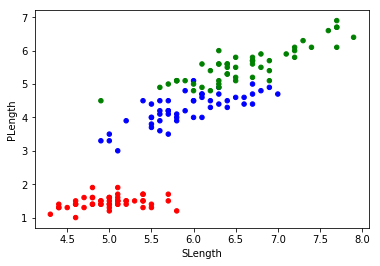

In [3]:
# Load the Dataset

cols = ["SLength", "SWidth", "PLength", "PWidth", "Class"]
types = ["Setosa", "Versicolor", "Virginica"]
iris = pd.read_csv("iris-data.txt", sep="\t", names=cols)


# Plot the values (plotting is done via pandas)

colors = [{1:'red', 2:'blue', 3:'green'}[i] for i in iris.Class]
iris.plot.scatter(x='SLength', y='PLength', c=colors)

In [0]:
# Split the Dataset into Training and Testing

iris_len = pd.DataFrame([iris.SLength, iris.PLength, iris.Class]).transpose()
train, test = ms.train_test_split(iris_len, test_size=0.3, random_state=1)
cTrain, cTest = train.pop('Class'), test.pop('Class')

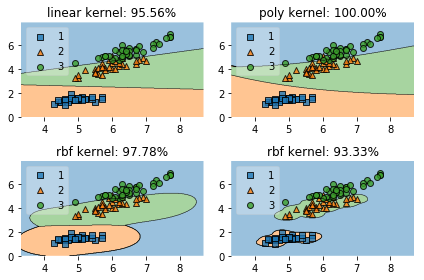

In [5]:
# Test the trained model with various SVM models and visualize them

for params,p in [({'kernel': 'linear', 'C': 1.0}, 221),
                 ({'kernel': 'poly', 'gamma': 0.1}, 222),
                 ({'kernel': 'rbf', 'gamma': 1}, 223),
                 ({'kernel': 'rbf', 'gamma': 20}, 224)
                ]:
    
    # Classifier
    clf = svm.SVC(**params)
    clf.fit(train, cTrain)

    # Predict
    accuracy = accuracy_score(cTest, clf.predict(test)) *100

    # Visualise the Hyper-plane
    X, Y = train.values, cTrain.values.astype(pd.np.integer)
    
    ttl = "%s kernel: %.2f%%" % (params['kernel'], accuracy)
    plt.subplot(p)
    plt.title(ttl)
    plot_decision_regions(X=X, y=Y, clf=clf, legend=2)
    
plt.tight_layout()
plt.show()

## SVM for Imagery using sklearn

In [0]:
# Importing the modules

import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn import svm
import numpy as np
import gdal

In [7]:
# Load the dataset
ds = gdal.Open("Dataset.tif")
imgArr = np.zeros((ds.RasterXSize, ds.RasterYSize, ds.RasterCount), np.int16)
for band in range(ds.RasterCount):
    imgArr[:,:,band] = ds.GetRasterBand(band+1).ReadAsArray() 

# Load the Training class raster
train_ds = gdal.Open("trainingSites.tif")
trainArr = train_ds.GetRasterBand(1).ReadAsArray()
print("Training classes present: ", np.unique(trainArr))

# Inorder to test the accuracy of SVM Classifier, it is assumed that
# MLC classifier performed in ArcGIS is 100% accurate.

# Load the Maximum Likelihood classified raster (GroundTruth Values)
MLC_ds = gdal.Open("MaxLikelihood.tif")
MLCArr = MLC_ds.GetRasterBand(1).ReadAsArray()

Training classes present:  [0 1 2 3 4]


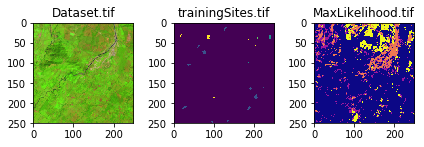

In [8]:
# Visualize the dataset and training using matplotlib

# Converted to 8-bit image using np.interp just for visualization
imgPlt = np.interp(imgArr,
                   (imgArr.min(), imgArr.max()), 
                   (0,255)).astype(np.uint8)

plt.subplot(131)
plt.imshow(imgPlt[:,:,(4,3,2)])
plt.title("Dataset.tif")

plt.subplot(132)
plt.imshow(trainArr)
plt.title("trainingSites.tif")

plt.subplot(133)
plt.imshow(MLCArr, cmap='plasma')
plt.title("MaxLikelihood.tif")

plt.tight_layout()
plt.show()

In [9]:
classes = ["Forest", "Urban", "Water", "Barren Land"]

# Prepare the Dataset for Training
mask = trainArr > 0
trainX = imgArr[mask]
trainY = trainArr[mask]
print(trainX.shape, trainY.shape)

(573, 8) (573,)


In [10]:
# Helper functions and variables for model training and reporting

# Create a new shape for predicting the whole image
newShape = (imgArr.shape[0] * imgArr.shape[1], imgArr.shape[2])
print("New Shape:", newShape)

# Prepare the MLC array for classifier report
testArr = imgArr.reshape(newShape)
goldStd = MLCArr.reshape(newShape[0])

# Generic function for printing out the classifier's report
def print_report(predicted):
    accuracy = accuracy_score(goldStd, predicted)
    print(f"Accuracy: {accuracy*100:.2f} %")
    print(classification_report(goldStd, predicted, target_names=classes))
    print(confusion_matrix(goldStd, predicted_lin))

New Shape: (62500, 8)


In [11]:
# Train the SVM Linear model with C 0.9
clfLinear = svm.SVC(kernel="linear", C=0.9)
clfLinear.fit(trainX, trainY)

# Predict for the whole image
predicted_lin = clfLinear.predict(testArr)

# Print the classifier reports
print_report(predicted_lin)

Accuracy: 81.96 %
              precision    recall  f1-score   support

      Forest       0.87      1.00      0.93     48203
       Urban       0.13      0.06      0.08      5325
       Water       0.67      0.08      0.14      4483
 Barren Land       0.56      0.57      0.56      4489

   micro avg       0.82      0.82      0.82     62500
   macro avg       0.56      0.42      0.43     62500
weighted avg       0.77      0.82      0.77     62500

[[48025     0    76   102]
 [ 4563   313    35   414]
 [  814  1821   340  1508]
 [ 1621   271    53  2544]]


In [12]:
# Train the SVM polynomial model with gamma 1.0
clfPoly = svm.SVC(kernel="poly", gamma=1.0, coef0=100)
clfPoly.fit(trainX, trainY)

# Predict for the whole image
predicted_poly = clfPoly.predict(testArr)

# Print the classifier reports
print_report(predicted_poly)

Accuracy: 82.05 %
              precision    recall  f1-score   support

      Forest       0.92      0.97      0.94     48203
       Urban       0.17      0.10      0.12      5325
       Water       0.52      0.07      0.12      4483
 Barren Land       0.46      0.78      0.58      4489

   micro avg       0.82      0.82      0.82     62500
   macro avg       0.52      0.48      0.44     62500
weighted avg       0.79      0.82      0.79     62500

[[48025     0    76   102]
 [ 4563   313    35   414]
 [  814  1821   340  1508]
 [ 1621   271    53  2544]]


In [13]:
# Train the SVM RBF (Radial Bias Function) model with gamma 1.0
clfRBF = svm.SVC(kernel="rbf", gamma=1.0)
clfRBF.fit(trainX, trainY)

# Predict for the whole image
predicted_rbf = clfRBF.predict(testArr)

# Print the classifier reports
print_report(predicted_rbf)

Accuracy: 77.24 %
              precision    recall  f1-score   support

      Forest       0.77      1.00      0.87     48203
       Urban       0.00      0.00      0.00      5325
       Water       0.88      0.00      0.01      4483
 Barren Land       0.55      0.01      0.03      4489

   micro avg       0.77      0.77      0.77     62500
   macro avg       0.55      0.25      0.23     62500
weighted avg       0.70      0.77      0.68     62500

[[48025     0    76   102]
 [ 4563   313    35   414]
 [  814  1821   340  1508]
 [ 1621   271    53  2544]]


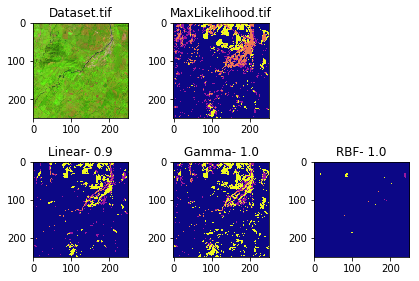

In [14]:
# Convert the predicted shape to image shape
imgShp = MLCArr.shape

# Visualise the Image again!
plt.subplot(231)
plt.imshow(imgPlt[:,:,(4,3,2)])
plt.title("Dataset.tif")

# Visualise the MLC again!
plt.subplot(232)
plt.imshow(MLCArr, cmap='plasma')
plt.title("MaxLikelihood.tif")

# Visualise the Predicted classes Rasters
plt.subplot(234)
plt.imshow(predicted_lin.reshape(imgShp), cmap='plasma')
plt.title("Linear- 0.9")

plt.subplot(235)
plt.imshow(predicted_poly.reshape(imgShp), cmap='plasma')
plt.title("Gamma- 1.0")

plt.subplot(236)
plt.imshow(predicted_rbf.reshape(imgShp), cmap='plasma')
plt.title("RBF- 1.0")

plt.tight_layout()
plt.show()